In [16]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 61.9 MB/s eta 0:00:0000:0100:01


In [56]:
file_path = "/Users/odunayoogundepo/Downloads/test_images_karanta/pdf/dictionary/dictionaryoftebe00elliuoft_page_292.pdf"

In [57]:
from pypdf import PdfReader
from pdf2image import convert_from_path


def load_pdf_as_images(pdf_path, page_range=1):
    """
    Load PDF pages as images using pypdf and pdf2image.

    Args:
        pdf_path (str): Path to the PDF file
        page_range (tuple): (start, end) page numbers (1-indexed), None for all pages

    Returns:
        list: List of PIL Images, one per page
    """
    try:
        # First, get PDF info using pypdf
        reader = PdfReader(pdf_path)
        total_pages = len(reader.pages)

        print(f"PDF has {total_pages} pages")

        # Determine page range
        if page_range:
            start_page = 1
            end_page = 1
            first_page = start_page
            last_page = end_page
        else:
            first_page = 1
            last_page = total_pages

        # Convert PDF pages to images using pdf2image
        images = convert_from_path(
            pdf_path, dpi=500, first_page=first_page, last_page=last_page, fmt="PNG"
        )

        print(f"Loaded {len(images)} pages as images")
        return images

    except Exception as e:
        print(f"Error loading PDF {pdf_path}: {str(e)}")
        return []


images = load_pdf_as_images(file_path)

PDF has 1 pages
Loaded 1 pages as images


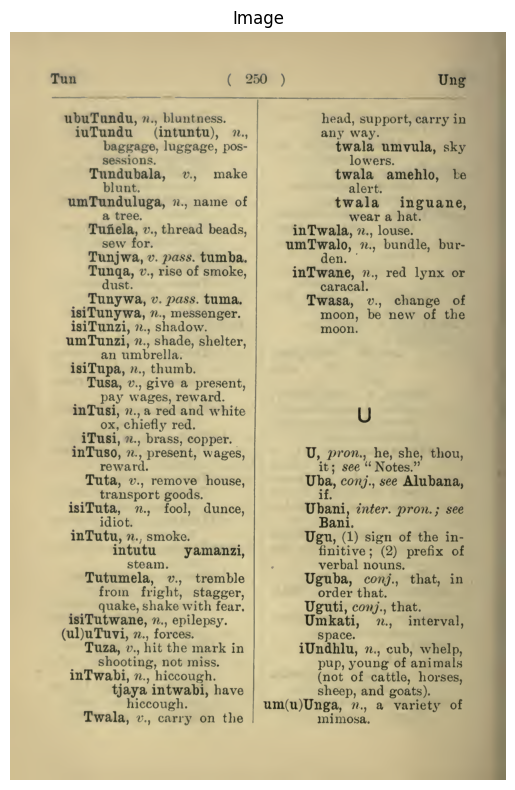

In [58]:
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


def show_image(image, title="Image", figsize=(12, 8)):
    """
    Display an image using matplotlib.

    Args:
        image: PIL Image or numpy array
        title (str): Title for the plot
        figsize (tuple): Figure size (width, height)
    """
    plt.figure(figsize=figsize)

    if isinstance(image, Image.Image):
        plt.imshow(image, cmap="gray" if image.mode == "L" else None)
    else:
        plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


show_image(images[0])

In [63]:
import cv2
import numpy as np


def enhance_document_quality(image, method="adaptive"):
    """
    Improve document quality by cleaning background and sharpening text.

    Args:
        image: PIL Image
        method (str): 'adaptive', 'otsu', 'enhanced', or 'aggressive'

    Returns:
        PIL Image: Processed image
    """

    # image = Image.fromarray(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY))

    # Convert PIL to OpenCV format
    if image.mode != "L":
        image = image.convert("L")
    img_array = np.array(image)

    if method == "adaptive":
        return _adaptive_threshold_method(img_array)
    elif method == "otsu":
        return _otsu_method(img_array)
    elif method == "enhanced":
        return _enhanced_method(img_array)
    elif method == "aggressive":
        return _aggressive_cleaning_method(img_array)
    elif method == "stackoverflow":
        return stackoverflow(img_array)
    else:
        return Image.fromarray(img_array)


def stackoverflow(img_array):
    dilated_img = cv2.dilate(img_array, np.ones((7, 7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 10)
    diff_img = 255 - cv2.absdiff(img_array, bg_img)
    norm_img = cv2.normalize(
        diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1
    )

    # Threshold using Otsu's
    work_img = cv2.threshold(norm_img, 0, 255, cv2.THRESH_OTSU)[1]

    return Image.fromarray(work_img)


def _adaptive_threshold_method(img_array):
    """Adaptive thresholding method - good for varying lighting."""
    # Denoise
    denoised = cv2.bilateralFilter(img_array, 9, 75, 75)

    # Adaptive threshold
    denoised = cv2.adaptiveThreshold(
        denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    return Image.fromarray(denoised)


def _otsu_method(img_array):
    """Otsu's method - automatically finds optimal threshold."""
    # Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img_array, (5, 5), 0)

    # Otsu's thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return Image.fromarray(thresh)


def _enhanced_method(img_array):
    """Enhanced method using PIL for more control."""
    img = Image.fromarray(img_array)

    # Enhance contrast
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(1.5)

    # Enhance sharpness
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)

    # Convert back to array for thresholding
    img_array = np.array(img)

    # Apply adaptive threshold
    thresh = cv2.adaptiveThreshold(
        img_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 8
    )

    return Image.fromarray(thresh)


def _aggressive_cleaning_method(img_array):
    """Aggressive cleaning for very noisy documents."""
    # Heavy denoising
    denoised = cv2.bilateralFilter(img_array, 15, 100, 100)

    # Morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    cleaned = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)

    # Adaptive threshold with larger neighborhood
    thresh = cv2.adaptiveThreshold(
        cleaned, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 10
    )

    # Final morphological closing to connect text
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    final = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel2)

    return Image.fromarray(final)

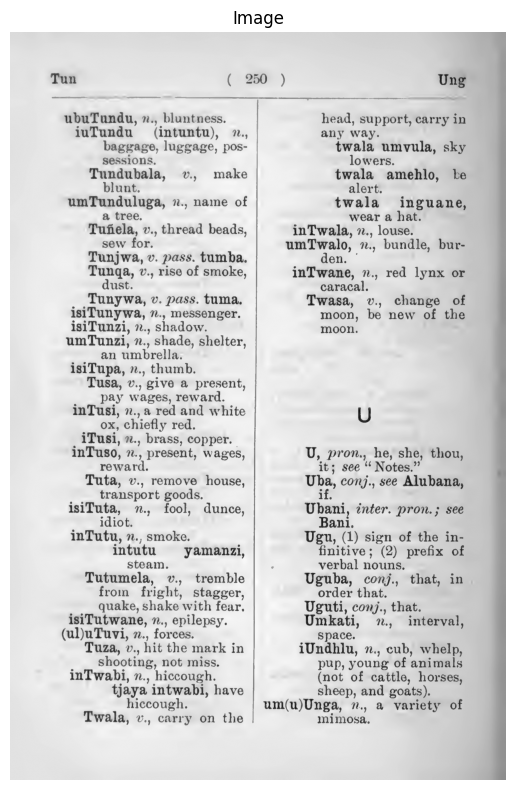

In [64]:
show_image(enhance_document_quality(images[0], method=None))